# Model creation (single taxel)

In [28]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Setup

In [56]:
# Imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from tools import common_functions as cf
from tools import regression as reg
from tools import plotting_functions as pf

# Parameters
SENSOR_LAG = 25 # ms
ARRAY_W = 1
ARRAY_H = 1
NR_SUBREGIONS = 1
DATA_NORMAL_FORCE_FILE = f"table_calibration/taxel0_calibration_28032024"
TAXEL_ID = 0

# Automated
ARRAY_SIZE = ARRAY_W * ARRAY_H
ARRAY_SIZE_SUB = (ARRAY_W + (ARRAY_W - 1) * (NR_SUBREGIONS - 1)) * (ARRAY_H + (ARRAY_H - 1) * (NR_SUBREGIONS - 1))
data_columns = [f'X{i}' for i in range(ARRAY_SIZE)] + [f'Y{i}' for i in range(ARRAY_SIZE)] + [f'Z{i}' for i in range(ARRAY_SIZE)]


# Model


In [57]:
original_data_df = cf.prepare_data_for_fitting(DATA_NORMAL_FORCE_FILE, ARRAY_SIZE, SENSOR_LAG, False)
original_data_df.info()

z_data = original_data_df[original_data_df['level_sensor'] == -3]

<class 'pandas.core.frame.DataFrame'>
Int64Index: 112688 entries, 1 to 112688
Data columns (total 25 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   index         112688 non-null  int64  
 1   t_wall        112688 non-null  float64
 2   level_sensor  112688 non-null  float64
 3   X0            112688 non-null  float64
 4   Y0            112688 non-null  float64
 5   Z0            112688 non-null  float64
 6   X1            112688 non-null  float64
 7   Y1            112688 non-null  float64
 8   Z1            112688 non-null  float64
 9   X2            112688 non-null  float64
 10  Y2            112688 non-null  float64
 11  Z2            112688 non-null  float64
 12  X3            112688 non-null  float64
 13  Y3            112688 non-null  float64
 14  Z3            112688 non-null  float64
 15  level_robot   112688 non-null  float64
 16  F_x           112688 non-null  float64
 17  F_y           112688 non-null  float64
 18  F_z 

/home/lowiek/masters-thesis/notebooks/tools/common_functions.py:286: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  data[col] -= np.mean(data[col][:window])


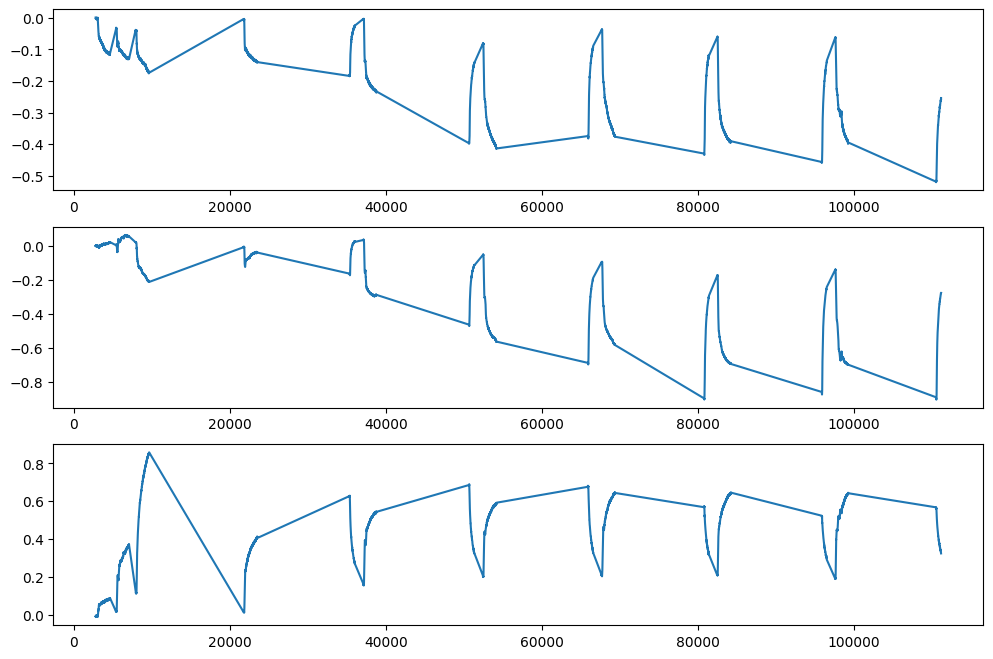

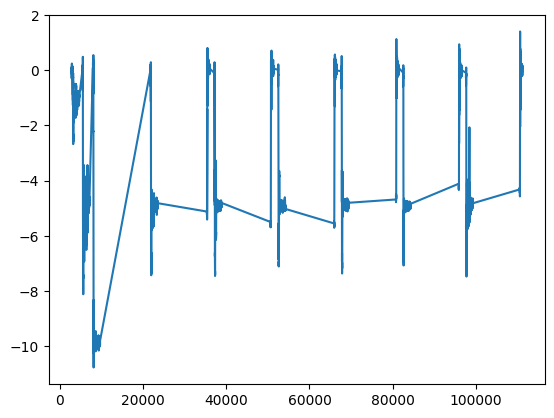

In [58]:
pf.plot_taxel(z_data, TAXEL_ID)

plt.plot(z_data['F_z'])
plt.show()

In [59]:
columns = [f'X{TAXEL_ID}', f'Y{TAXEL_ID}',f'Z{TAXEL_ID}']

X = original_data_df[columns]
Y = original_data_df[['F_x', 'F_y', 'F_z']]

model = reg.create_regression_pipeline_and_fit(X, Y)

Score:  0.7356508755538879
MSE:  1.6102482981997681


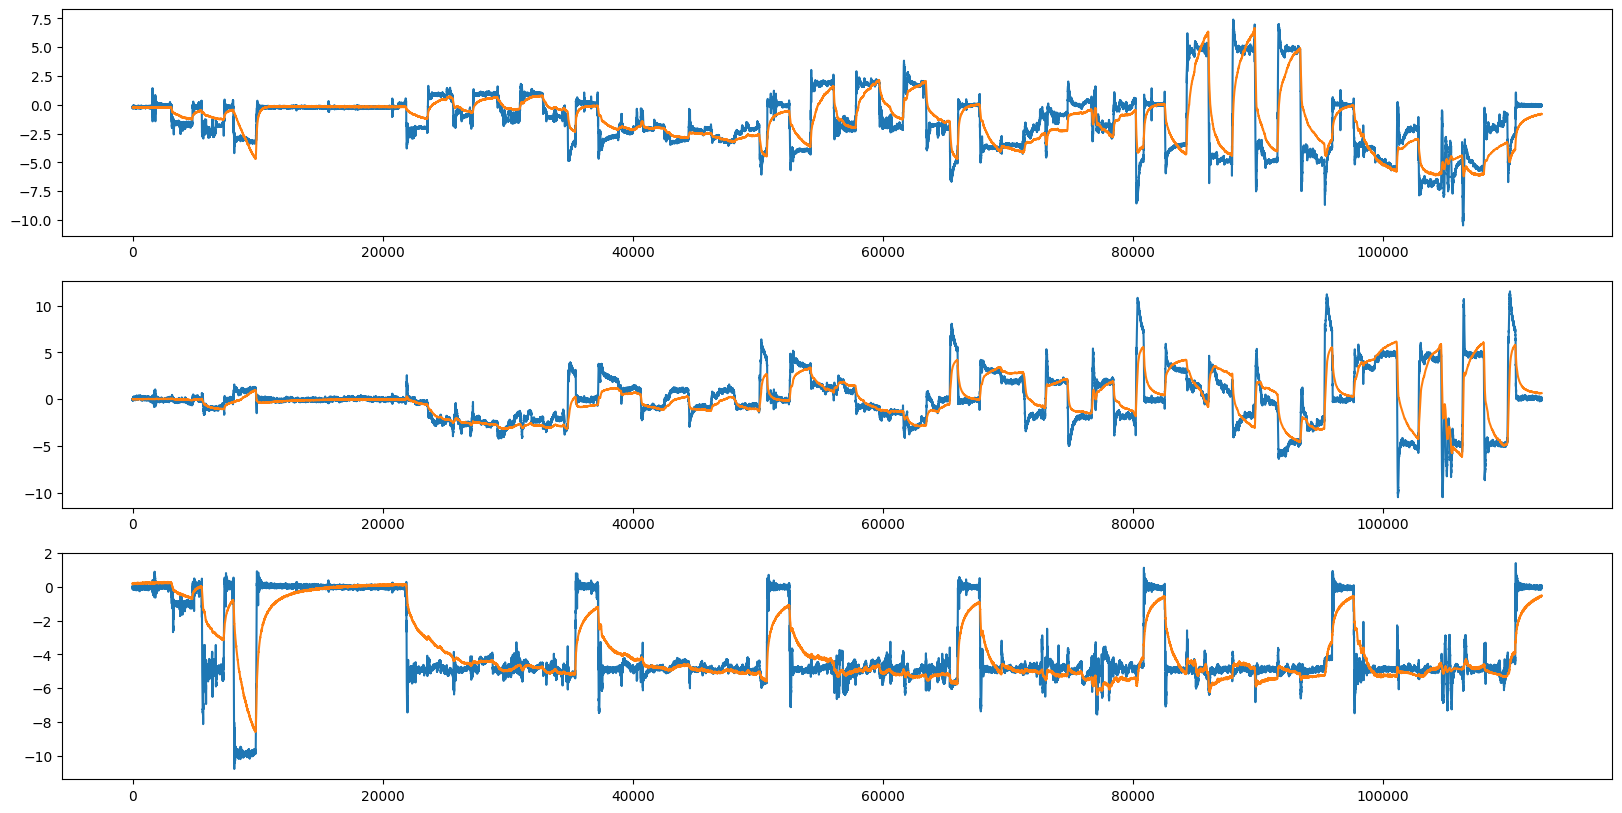

In [60]:
# Plot prediction (of complete run)
Y_pred = model.predict(original_data_df[columns])

pred_X = Y_pred[:, 0]
pred_Y = Y_pred[:, 1]
pred_Z = Y_pred[:, 2]

fig, ax = plt.subplots(3, 1, figsize=(20, 10))
ax[0].plot(original_data_df['F_x'], label='True')
ax[0].plot(pred_X)

ax[1].plot(original_data_df['F_y'], label='True')
ax[1].plot(pred_Y)

ax[2].plot(original_data_df['F_z'], label='True')
ax[2].plot(pred_Z)


# Z-model
Split into regions of each taxel, then train one model per taxel 
A model is thus 3 inputs -> 3 outputs

In [3]:
normal_force_df = cf.prepare_data_for_fitting(DATA_NORMAL_FORCE_FILE, ARRAY_SIZE, SENSOR_LAG, False)
normal_force_df.info()

/home/lowiek/masters-thesis/notebooks/tools/common_functions.py:286: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  data[col] -= np.mean(data[col][:window])


<class 'pandas.core.frame.DataFrame'>
Int64Index: 627913 entries, 1 to 627913
Data columns (total 25 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   index         627913 non-null  int64  
 1   t_wall        627913 non-null  float64
 2   level_sensor  627913 non-null  float64
 3   X0            627913 non-null  float64
 4   Y0            627913 non-null  float64
 5   Z0            627913 non-null  float64
 6   X1            627913 non-null  float64
 7   Y1            627913 non-null  float64
 8   Z1            627913 non-null  float64
 9   X2            627913 non-null  float64
 10  Y2            627913 non-null  float64
 11  Z2            627913 non-null  float64
 12  X3            627913 non-null  float64
 13  Y3            627913 non-null  float64
 14  Z3            627913 non-null  float64
 15  level_robot   627913 non-null  float64
 16  F_x           627913 non-null  float64
 17  F_y           627913 non-null  float64
 18  F_z 

In [4]:
# Calculate magnitude and angle

normal_force_df['F_m'] = np.sqrt(normal_force_df['F_x']**2 + normal_force_df['F_y']**2 + normal_force_df['F_z']**2)
normal_force_df['F_xy'] = np.sqrt(normal_force_df['F_x']**2 + normal_force_df['F_y']**2)
normal_force_df['F_t'] = np.arctan2(normal_force_df['F_y'], normal_force_df['F_x']) 
for i in range(4):
  normal_force_df[f'M{i}'] = np.sqrt(normal_force_df['X0']**2 + normal_force_df['Y0']**2 + normal_force_df['Z0']**2)
  normal_force_df[f'XY{i}'] = np.sqrt(normal_force_df['X0']**2 + normal_force_df['Y0']**2)
  normal_force_df[f'T{i}'] = np.arctan2(normal_force_df['Y0'], normal_force_df['X0'])

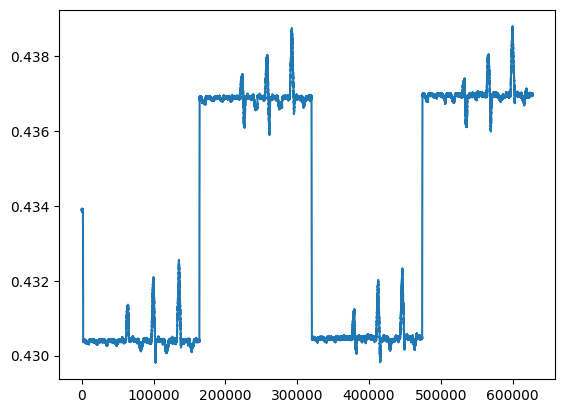

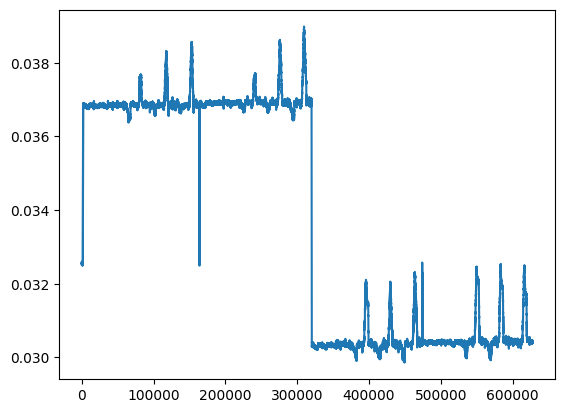

In [5]:
X = normal_force_df['X']
Y = normal_force_df['Y']

plt.plot(X)
plt.show()

plt.plot(Y)
plt.show()

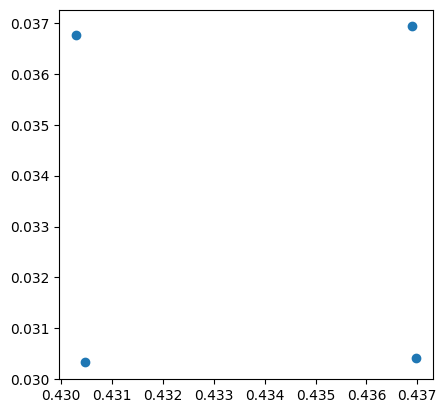

In [6]:
# Extract boundary points
# center_points, normal_force_normalized_df = cf.extract_center_points_from_data(normal_force_df, ARRAY_SIZE_SUB, normalize=True) 

# Done manually
center_points = np.array([[X[10000], Y[10000]], [X[200000], Y[200000]], [X[350000], Y[350000]], [X[495000], Y[495000]]])
#center_points = np.array([[X[50000], Y[50000]], [X[200000], Y[200000]]])
plt.scatter(center_points[:,0], center_points[:,1])
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

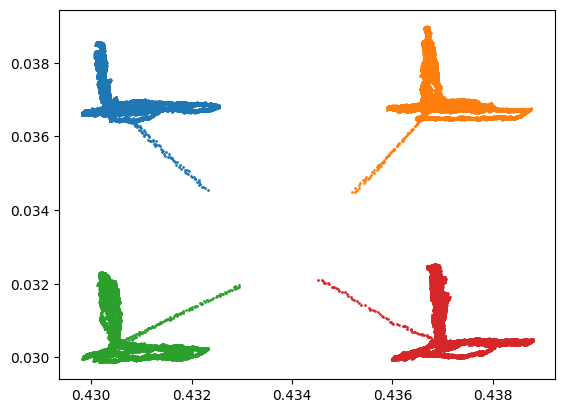

In [7]:
# Now split into the regions used for fitting
regions_data = cf.split_data_into_regions(normal_force_df, center_points, min_distance=0.003)

for data in regions_data:
  plt.scatter(data['X'], data['Y'],s=1)
plt.show()

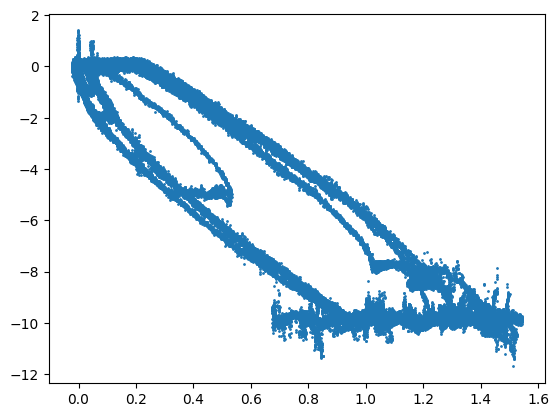

In [19]:
plt.scatter(regions_data[0]['Z2'], regions_data[0]['F_z'], s=1)

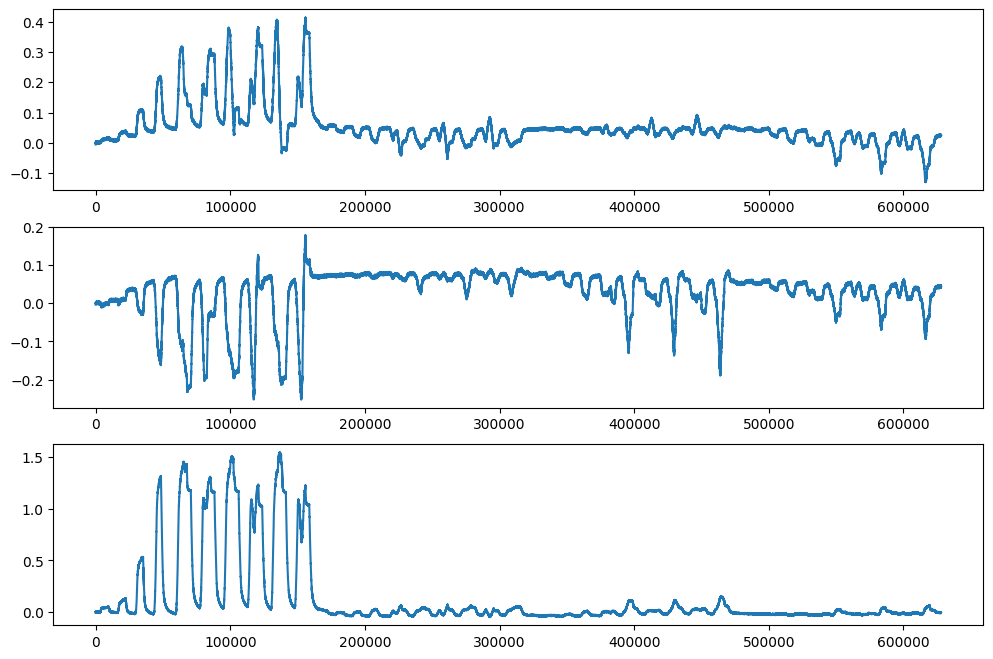

In [8]:
pf.plot_taxel(normal_force_df, 2)

In [20]:
normal_force_models_taxels = []

for j, region in enumerate(regions_data):
  
  # Find largest activation 
  Z_measurements = region[ [f'Z{i}' for i in range(ARRAY_SIZE)]]
  largest_activation_in_region_index =  np.argmax(np.max(Z_measurements) - np.min(Z_measurements))
  
  print("Taxel {} has largest activation".format(largest_activation_in_region_index))
  
  columns = [f'Z{largest_activation_in_region_index}']
  
  X = region[columns]#[f'Z{largest_activation_in_region_index}']]
  y = region[['F_z']]
  
  # Fit
  model = reg.create_regression_pipeline_and_fit(X, y)
  model.activation_index = largest_activation_in_region_index
  
  normal_force_models_taxels.append(model)
  
  print("\n\n")
  

Taxel 2 has largest activation
Score:  0.9233782303495603
MSE:  1.3794531531295633



Taxel 3 has largest activation
Score:  0.9334283029664848
MSE:  1.2529802265558174



Taxel 1 has largest activation
Score:  0.9455530800199581
MSE:  1.037307489615745



Taxel 0 has largest activation
Score:  0.8929845114062995
MSE:  2.012139854917851





/home/lowiek/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: In a future version, DataFrame.max(axis=None) will return a scalar max over the entire DataFrame. To retain the old behavior, use 'frame.max(axis=0)' or just 'frame.max()'
  return reduction(axis=axis, out=out, **passkwargs)
/home/lowiek/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: In a future version, DataFrame.min(axis=None) will return a scalar min over the entire DataFrame. To retain the old behavior, use 'frame.min(axis=0)' or just 'frame.min()'
  return reduction(axis=axis, out=out, **passkwargs)
/home/lowiek/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: In a future version, DataFrame.max(axis=None) will return a scalar max over the entire DataFrame. To retain the old behavior, use 'frame.max(axis=0)' or just 'frame.max()'
  return reduction(axis=axis, out=out, **passkwargs)
/home/lowiek/.local/lib/python3.10/site-pac

/home/lowiek/masters-thesis/notebooks/tools/common_functions.py:286: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  data[col] -= np.mean(data[col][:window])


<class 'pandas.core.frame.DataFrame'>
Int64Index: 21193 entries, 3 to 21195
Data columns (total 25 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   index         21193 non-null  int64  
 1   t_wall        21193 non-null  float64
 2   level_sensor  21193 non-null  float64
 3   X0            21193 non-null  float64
 4   Y0            21193 non-null  float64
 5   Z0            21193 non-null  float64
 6   X1            21193 non-null  float64
 7   Y1            21193 non-null  float64
 8   Z1            21193 non-null  float64
 9   X2            21193 non-null  float64
 10  Y2            21193 non-null  float64
 11  Z2            21193 non-null  float64
 12  X3            21193 non-null  float64
 13  Y3            21193 non-null  float64
 14  Z3            21193 non-null  float64
 15  level_robot   21193 non-null  float64
 16  F_x           21193 non-null  float64
 17  F_y           21193 non-null  float64
 18  F_z           21193 non-nu

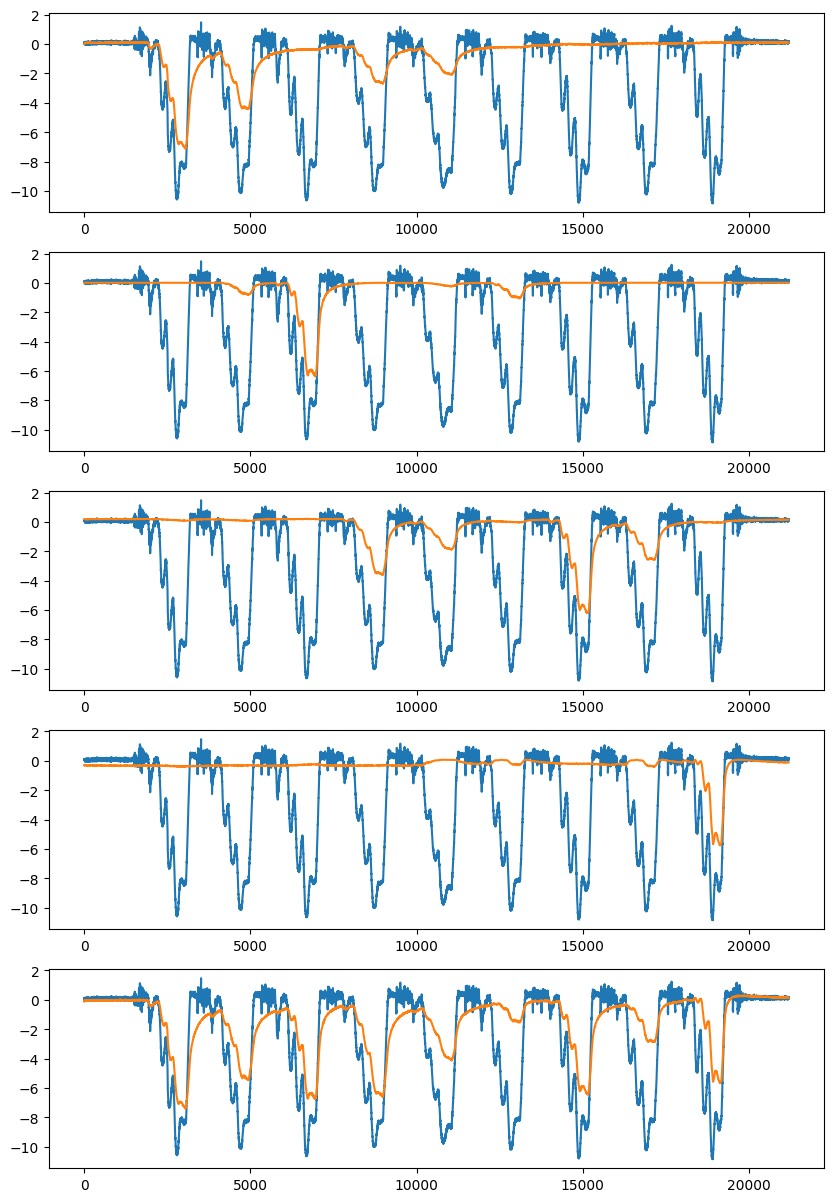

In [22]:
# Apply models on new data (with subsampling)
normal_force_df_val = cf.prepare_data_for_fitting(f"table_calibration/2x2_grid_subsampling_x2_20032024", ARRAY_SIZE, SENSOR_LAG, False)
z_data = normal_force_df_val
z_data.info()

normal_force_df_val = cf.extract_features(normal_force_df_val)

F_zi = [model.predict(z_data[[f'Z{model.activation_index}']]) for model in normal_force_models_taxels]

# Sort F_zi according to model.activation_index
# F_zi = [F_zi[model.activation_index] for model in normal_force_models_taxels]
F_zi = np.array(F_zi)[:, :, 0]


fig, axs = plt.subplots(ARRAY_SIZE + 1, 1, figsize=(10, 15))
for i in range(ARRAY_SIZE):
  # normal_force_df_val[f'F_xz{i}'] = F_zi[i] if letter == 'x' else F_yi[i] if letter == 'y' else F_zi[i]
  axs[i].plot(z_data[f'F_z'])
  axs[i].plot(F_zi[i])

axs[-1].plot(z_data[f'F_z'])
axs[-1].plot(np.sum(F_zi, axis=0))

plt.show()


In [57]:
# 
# XY models
#

# calculate the XY component 

columns = [f'X{i}' for i in range(ARRAY_SIZE)] + [f'Y{i}' for i in range(ARRAY_SIZE)]# + [f'Z{i}' for i in range(ARRAY_SIZE)]
x = normal_force_df[columns]
Y = normal_force_df[['F_xy']]

x_model = reg.create_regression_pipeline_and_fit(x, Y)

Score:  0.9212289996772082
MSE:  0.17587181744223643


<class 'pandas.core.frame.DataFrame'>
Int64Index: 20642 entries, 4 to 20645
Data columns (total 25 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   index         20642 non-null  int64  
 1   t_wall        20642 non-null  float64
 2   level_sensor  20642 non-null  float64
 3   X0            20642 non-null  float64
 4   Y0            20642 non-null  float64
 5   Z0            20642 non-null  float64
 6   X1            20642 non-null  float64
 7   Y1            20642 non-null  float64
 8   Z1            20642 non-null  float64
 9   X2            20642 non-null  float64
 10  Y2            20642 non-null  float64
 11  Z2            20642 non-null  float64
 12  X3            20642 non-null  float64
 13  Y3            20642 non-null  float64
 14  Z3            20642 non-null  float64
 15  level_robot   20642 non-null  float64
 16  F_x           20642 non-null  float64
 17  F_y           20642 non-null  float64
 18  F_z           20642 non-nu

/home/lowiek/masters-thesis/notebooks/tools/common_functions.py:286: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  data[col] -= np.mean(data[col][:window])


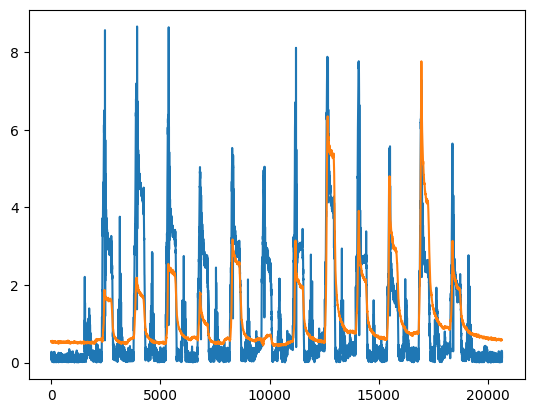

In [60]:
# Apply models on new data (with subsampling)
# 2x2_taxel_calibration_with_silicon
normal_force_df_val = cf.prepare_data_for_fitting(f"table_calibration/2x2_grid_xy_subsampling_x2_20032024", ARRAY_SIZE, SENSOR_LAG, False)
z_data = normal_force_df_val #normal_force_df_val[normal_force_df_val['level_sensor'] == -3].copy().reset_index()
z_data.info()

z_data = cf.extract_features(z_data)

F_x_pred = x_model.predict(z_data[columns])

plt.plot(z_data['F_xy'])
plt.plot(F_x_pred)

# XY model

## Estimate XY linearly

Actual point is just normalized weighted sum of the components

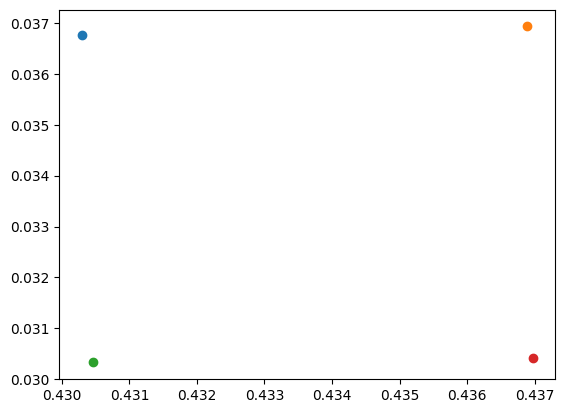

In [94]:
for i in range(ARRAY_SIZE):
  plt.scatter(center_points[i, 0], center_points[i, 1])

In [98]:
# sum( F_zi * center_point ) = F_z * actual_point

F_zia = F_zi[F_zi < -5]

parts = []
for i in range(F_zi.shape[0]):
  
  Xpart = F_zia[i] * center_points[i, 0]
  Ypart = F_zia[i] * center_points[i, 1]
  
  parts.append([Xpart, Ypart])

parts = np.array(parts)
print(parts.shape)

actual_point_x = np.sum(parts[:,0], axis=0) / np.sum(F_zia, axis=0)
actual_point_y = np.sum(parts[:,1], axis=0) / np.sum(F_zia, axis=0)

print(actual_point_x.shape)

index = 100000
plt.scatter(actual_point_x[:index], actual_point_y[:index], s=0.5)

plt.xlim((0.430, 0.44))
plt.ylim((0.03, 0.037))

plt.show()

plt.plot(np.sum(F_zi, axis=0))
plt.show()
  

(4, 2)
()


IndexError: invalid index to scalar variable.

# Option 1.1:
1 groot model in het algemeen
Dus Z0, Z1, Z2, Z3 -> F_z

In [ ]:
ARRAY_SUB_SIZE = 4
normal_force_df = cf.prepare_data_for_fitting("table_calibration/2x2_taxel_calibration_with_silicon", ARRAY_SIZE, SENSOR_LAG, False)

(627913, 25)
(627913, 25)


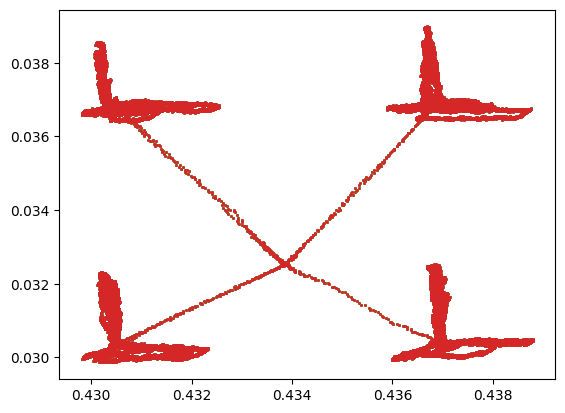

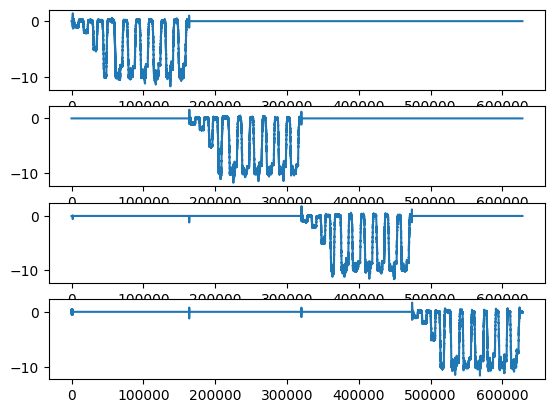

In [ ]:
full_regions = cf.split_data_into_regions_full(normal_force_df, center_points, data_columns + ['F_z'], min_distance=9999)

for data in full_regions:
  plt.scatter(data['X'], data['Y'],s=1)
plt.show()

fig, axs = plt.subplots(ARRAY_SUB_SIZE, 1)
for i in range(ARRAY_SUB_SIZE):
  axs[i].plot(full_regions[i][f'F_z'])
  # axs[i].set_ylim((0, 10))

In [ ]:
#Create a big model
X = normal_force_df[[f'Z{i}' for i in range(ARRAY_SIZE)]]
y = [region['F_z'] for region in full_regions]
y = np.array(y).T

print(X.shape)
print(y.shape)

big_model = reg.create_regression_pipeline_and_fit(X, y)

(627913, 4)
(627913, 4)
Score:  0.9737837114327432
MSE:  0.22310595003971959


/home/lowiek/.local/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=3.79699e-28): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


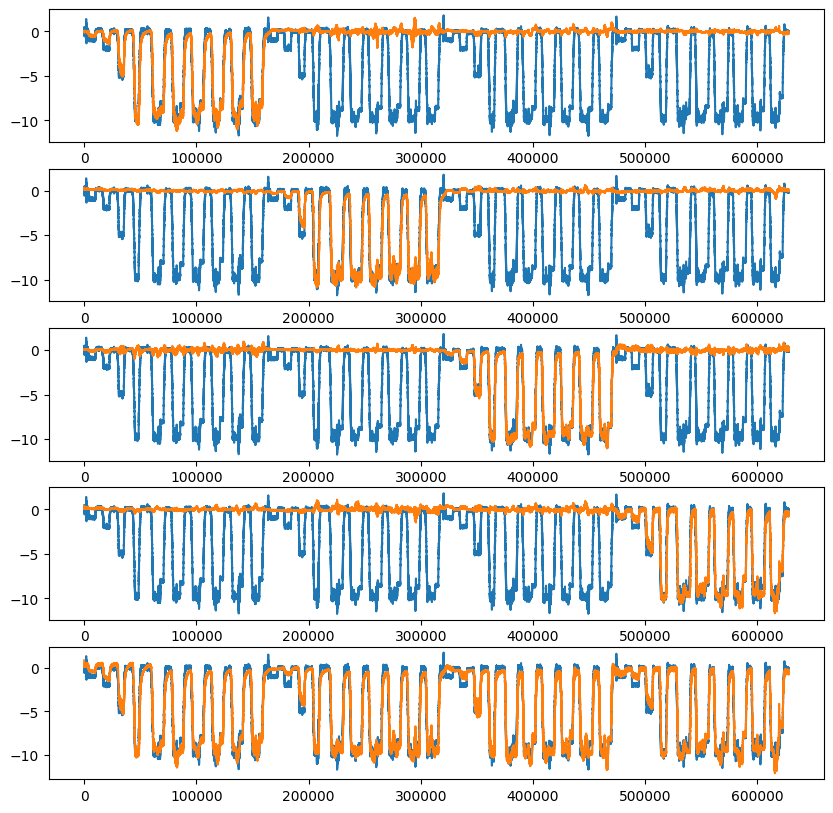

In [ ]:
# Apply models on new data (with subsampling)
normal_force_df_val = cf.prepare_data_for_fitting(f"table_calibration/2x2_taxel_calibration_with_silicon", ARRAY_SIZE, SENSOR_LAG, False)

normal_force_models_taxels_fixed = [normal_force_models_taxels[i] for i in [3, 2, 0, 1]]

X = normal_force_df_val[[f'Z{i}' for i in range(ARRAY_SIZE)]]
F_zi = big_model.predict(X)
F_zi = [F_zi[:, i] for i in range(ARRAY_SUB_SIZE)]

fig, axs = plt.subplots(ARRAY_SUB_SIZE + 1, 1, figsize=(10, 10))
for i in range(ARRAY_SUB_SIZE):
  axs[i].plot(normal_force_df_val[f'F_z'])
  axs[i].plot(F_zi[i])
  
  # axs[i].set_ylim((0, 10))

axs[-1].plot(normal_force_df_val['F_z'])
axs[-1].plot(np.sum(F_zi, axis=0))

plt.show()


# Option 1.2
Groot model per taxel
Per taxel: Xi, Yi, Zi for i in range(4) -> F_z

In [155]:
ARRAY_SUB_SIZE = 4
normal_force_df = cf.prepare_data_for_fitting("table_calibration/2x2_taxel_calibration_with_silicon", ARRAY_SIZE, SENSOR_LAG, False)

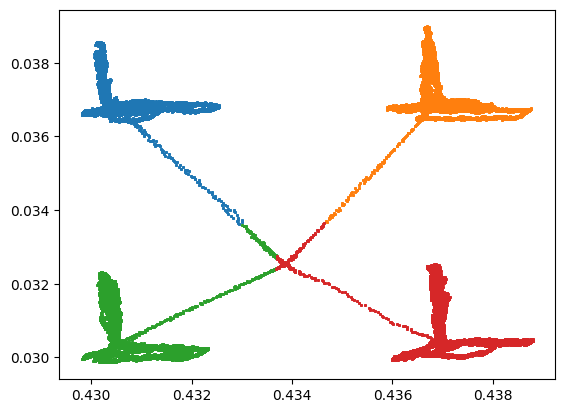

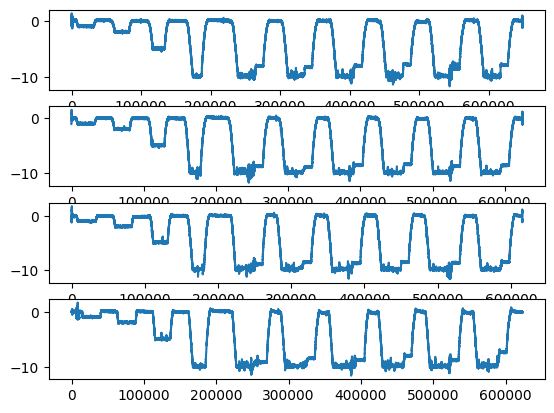

In [156]:
full_regions = cf.split_data_into_regions(normal_force_df, center_points, min_distance=9999)

for data in full_regions:
  plt.scatter(data['X'], data['Y'],s=1)
plt.show()

fig, axs = plt.subplots(ARRAY_SUB_SIZE, 1)
for i in range(ARRAY_SUB_SIZE):
  axs[i].plot(full_regions[i][f'F_z'])
  # axs[i].set_ylim((0, 10))

In [163]:
X = normal_force_df[[f'X{i}' for i in range(ARRAY_SIZE)]]
y = normal_force_df[['F_x']]

big_model = reg.create_regression_pipeline_and_fit(X, y)

Score:  0.7902486262350575
MSE:  0.22620128316113103


/home/lowiek/.local/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=8.77679e-27): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


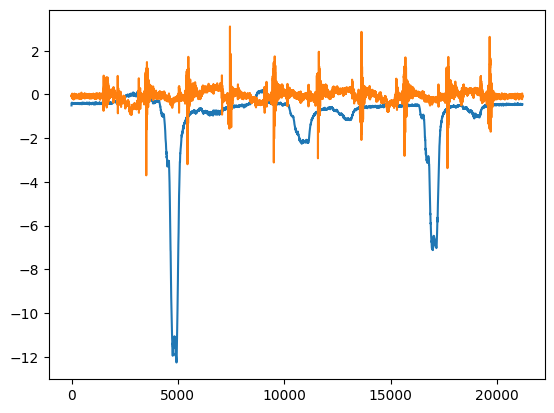

In [165]:
# Apply models on new data (with subsampling)
normal_force_df_val = cf.prepare_data_for_fitting(f"table_calibration/2x2_grid_subsampling_x2_20032024", ARRAY_SIZE, SENSOR_LAG, False)

X = normal_force_df_val[[f'X{i}' for i in range(ARRAY_SIZE)]]
F = big_model.predict(X)

plt.plot(F[:, 0])
plt.plot(normal_force_df_val['F_x'])
# plt.xlim((90000, 110000))
plt.show()

# plt.plot(F[:, 1])
# plt.plot(normal_force_df_val['F_y'])
# plt.show()

# plt.plot(F[:, 2])
# plt.plot(normal_force_df_val['F_z'])
# plt.show()


In [87]:
#Create a big model per taxel
taxel_models = []

print(data_columns)

for region in full_regions:
  
  X = region[data_columns]
  y = region['F_z']
  y = np.array(y).T

  print(X.shape)
  print(y.shape)

  taxel_models.append(reg.create_regression_pipeline_and_fit(X, y))

['X0', 'X1', 'X2', 'X3', 'Y0', 'Y1', 'Y2', 'Y3', 'Z0', 'Z1', 'Z2', 'Z3']
(648544, 12)
(648544,)
Score:  0.9893507503024871
MSE:  0.19157883404740328
(624400, 12)
(624400,)
Score:  0.9902412527887358
MSE:  0.18328595698941824
(615672, 12)
(615672,)
Score:  0.9946239381053149
MSE:  0.10265557785801156
(623036, 12)
(623036,)
Score:  0.9940706298707
MSE:  0.11206782693525072


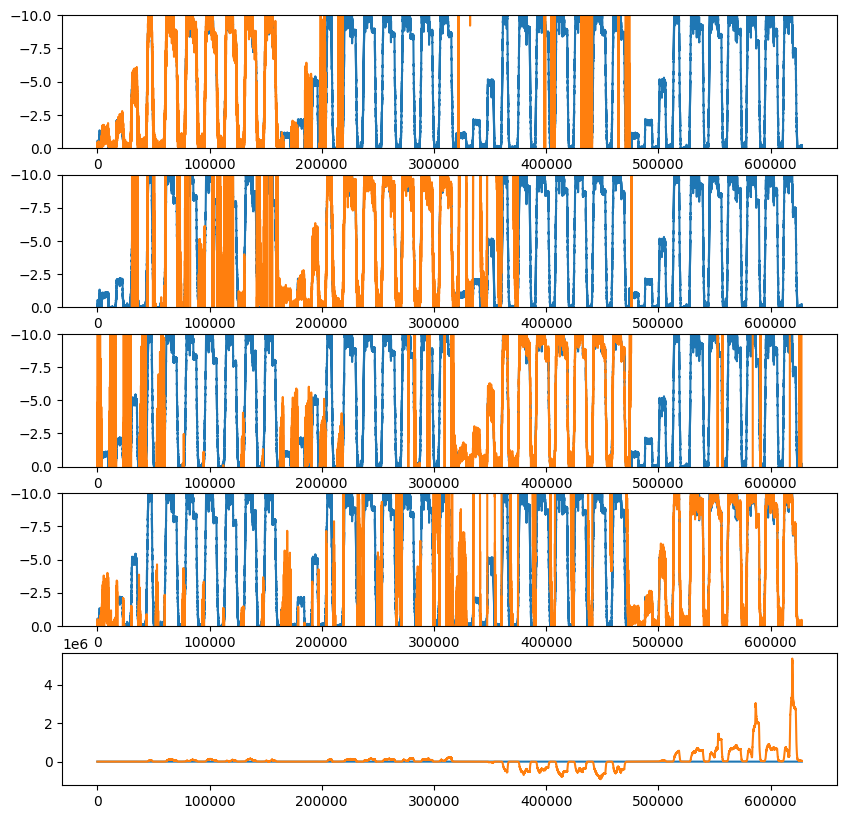

In [89]:
# Apply models on new data (with subsampling)
normal_force_df_val = cf.prepare_data_for_fitting(f"table_calibration/2x2_taxel_calibration_with_silicon", ARRAY_SIZE, SENSOR_LAG, False)

X = normal_force_df_val[data_columns]
F_zi = [model.predict(X) for model in taxel_models]

fig, axs = plt.subplots(ARRAY_SUB_SIZE + 1, 1, figsize=(10, 10))
for i in range(ARRAY_SUB_SIZE):
  axs[i].plot(normal_force_df_val[f'F_z'])
  axs[i].plot(F_zi[i])
  
  axs[i].set_ylim((0, -10))

axs[-1].plot(normal_force_df_val['F_z'])
axs[-1].plot(np.sum(F_zi, axis=0))

plt.show()


# Option 2
All Z-components -> F_z, X, Y

In [39]:
X = normal_force_df[[f'Z{i}' for i in range(ARRAY_SIZE)]]
y = normal_force_df[['F_z', 'X', 'Y']]

model_option_2 = reg.create_regression_pipeline_and_fit(X, y)

Score:  0.8853545949787504
MSE:  0.31825600088448663


/home/lowiek/.local/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=7.04606e-27): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


/home/lowiek/.local/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


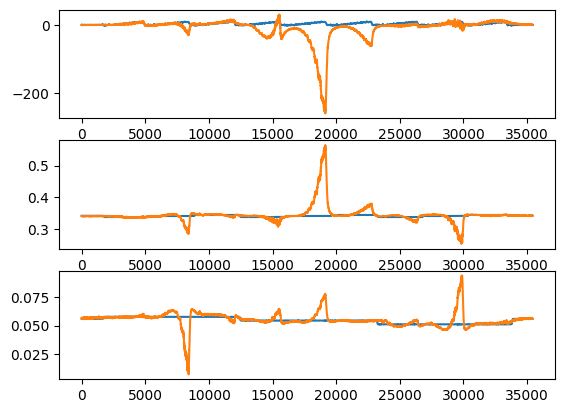

In [44]:
normal_force_df_val = cf.prepare_data_for_fitting(f"table_calibration/2x2_grid_subsampling_x2_08032024_schroef2", ARRAY_SIZE, SENSOR_LAG)
y = cf.validate_data(normal_force_df_val, model_option_2, ARRAY_SIZE)

fig, axs = plt.subplots(3, 1)

axs[0].plot(normal_force_df_val[f'F_z'])
axs[0].plot(y[:, 0])

axs[1].plot(normal_force_df_val[f'X'])
axs[1].plot(y[:, 1])

axs[2].plot(normal_force_df_val[f'Y'])
axs[2].plot(y[:, 2])

plt.show()


# Option 3: taxel model interpolation
So predict superresolution based on taxel models (from option 1)

In [144]:
def interpolate_normalized(F_zi, x, y):
  """
  Interpolate the force at a given point.
  F_zi should be (x1, y1), (x1, y2), (x2, y1), (x2, y2)
  """
  
  x1, y1 = 0, 0
  x2, y2 = 1, 1
  
  F_matrix = np.array([[F_zi[0], F_zi[1]], [F_zi[2], F_zi[3]]])
  
  tmp = np.zeros((2, F_matrix.shape[-1]))
  for i in range(F_matrix.shape[-1]):
    tmp[:, i] = F_matrix[:, :, i] @ np.array([y2 - y, y - y1]).T
  
  tmp2 = np.zeros((F_matrix.shape[-1]))
  for i in range(F_matrix.shape[-1]):
    tmp2[i] = np.array([x2 - x, x - x1]).T @ tmp[:, i]
  
  return 1 / ((x2 - x1) * (y2 - y1)) * tmp2
  

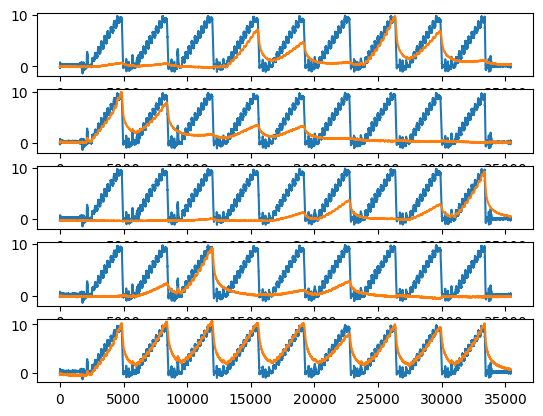

In [154]:
# We have a combined_model that returns the F_z components from every taxel based on the Z measurements
# Now we use this model to fit a model that predicts the F_z component, given Z measurements and the X and Y position of the wanted location
# OR we give it Z measurements, and it returns the F_z component at all virtual locations at once

# First we make the predictions from the option 1 models
subsampled_force_df = cf.prepare_data_for_fitting(f"table_calibration/2x2_grid_subsampling_x2_08032024_schroef2", ARRAY_SIZE, SENSOR_LAG)
F_zi = combined_model.predict(subsampled_force_df[[f'Z{i}' for i in range(ARRAY_SIZE)]].to_numpy())
F_zi_fixed = [F_zi[:, 1], F_zi[:, 2], F_zi[:, 0], F_zi[:, 3]]

fig, axs = plt.subplots(ARRAY_SIZE + 1, 1)
for i in range(ARRAY_SIZE):
  axs[i].plot(subsampled_force_df[f'F_z'])
  axs[i].plot(F_zi_fixed[i])

axs[-1].plot(subsampled_force_df['F_z'])
axs[-1].plot(np.sum(F_zi_fixed, axis=0))

plt.show()

(9, 35428)


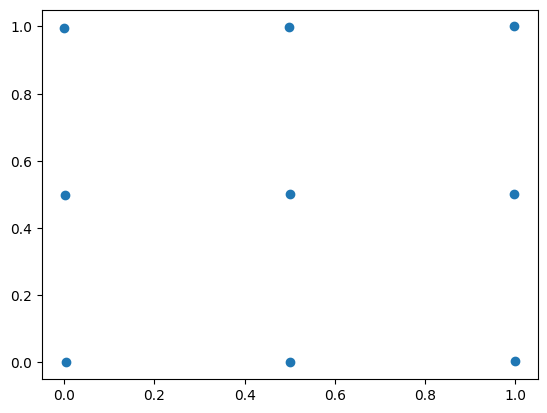

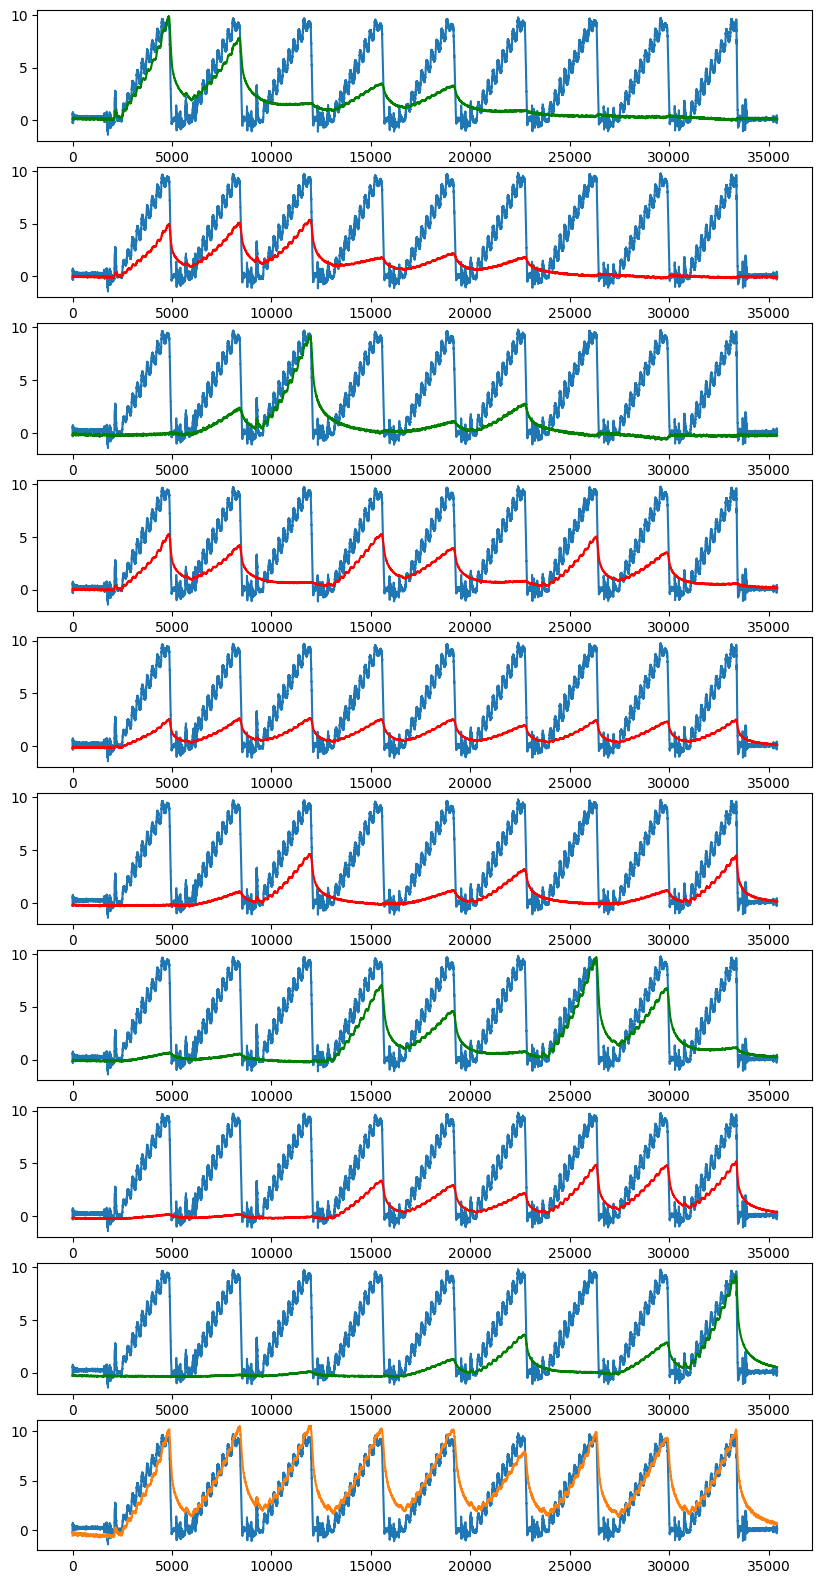

In [158]:
# Test the interpolation model on the different points
array_size = 9
center_points_val, _ = cf.extract_center_points_from_data(subsampled_force_df, array_size, normalize=True)
plt.scatter(center_points_val[:,0], center_points_val[:,1])

F_zi_int = []

for point in center_points_val:
  F_zi_int.append(interpolate_normalized([F_zi[:, 1], F_zi[:, 2], F_zi[:, 0], F_zi[:, 3]], point[0], point[1]))
  
fig, axs = plt.subplots(array_size + 1, 1, figsize=(10, 20))
for i in range(array_size):
  c = 'r'
  if i == 0 or i == 2 or i == 6 or i == 8:
    c = 'g'
    
  axs[i].plot(subsampled_force_df[f'F_z'])
  axs[i].plot(F_zi_int[i], c=c)

axs[-1].plot(subsampled_force_df['F_z'])
axs[-1].plot(np.sum(F_zi_int, axis=0) / array_size * 4)

# Option 4: superresolution based on previous model
So we take the Z measurements of a 4x4 model, we put it in to the big model (option 1 or something like that), we get the F_z components out. Then we put those components into a new model, together with XY and predict F_z

(59476, 23)
(59476, 23)


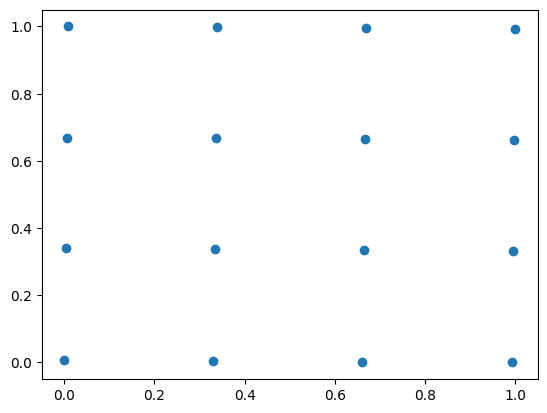

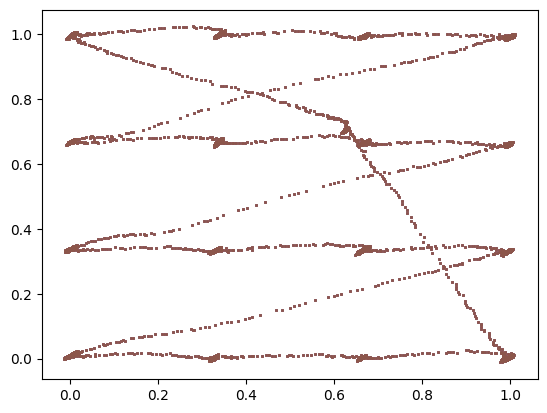

In [124]:
# First load in superresolution data
# Step 0
array_size = 4
array_sub_size = 16
super_res_df = cf.prepare_data_for_fitting(f"table_calibration/2x2_grid_subsampling_x3_08032024_schroef2", array_size, SENSOR_LAG)
center_points_sr, super_res_normalized_df = cf.extract_center_points_from_data(super_res_df, array_sub_size, normalize=True)

# Split into regions
full_regions_sr = cf.split_data_into_regions_full(super_res_normalized_df, center_points_sr, data_columns + ['F_z'], min_distance=0.1)

plt.scatter(center_points_sr[:,0], center_points_sr[:,1])
plt.show()

for data in full_regions_sr:
  plt.scatter(data['X'], data['Y'],s=1)

Score:  0.8114805049672812
MSE:  0.26450324511422396


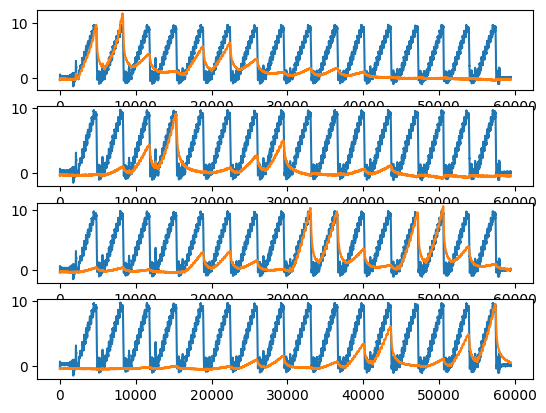

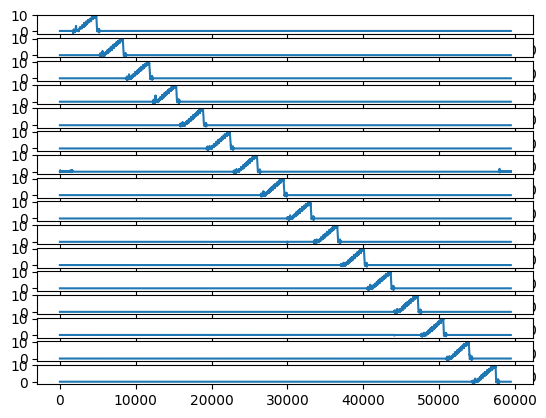

In [125]:
#
# AGGREGATED MODEL PER VIRTUAL TAXEL (UNCOUPLED)
#
# # Now make an aggregated model per virtual taxel. Taking in the forces on the actual taxels
# aggregate_models = []

# F_zis = []

# for region in full_regions_sr:

#     # Predict forces on the actual taxels (big model)
#     X = region[[f'Z{i}' for i in range(array_size)]]
#     F_zi = []
#     for model in normal_force_models_taxels:
#         F_zi.append(model.predict(X[f'Z{model.activation_index}'].to_numpy().reshape(-1, 1))[:, 0])
    
#     F_zi = np.array(F_zi).T
#     F_zis.append(F_zi)

#     # Now give this as input, together with the F_z of the region
#     y = region['F_z']
#     model = reg.create_regression_pipeline_and_fit(F_zi, y)
#     aggregate_models.append(model)

#
# ONE BIG AGGREGATED MODEL
#
# Now make one big aggregated model, taking in the forces on the actual taxels
F_zi = []
F_zi = []
X = super_res_normalized_df[[f'Z{i}' for i in range(array_size)]]
for model in normal_force_models_taxels:
    F_zi.append(model.predict(X[f'Z{model.activation_index}'].to_numpy().reshape(-1, 1))[:, 0])
    
# Plot
fig, axs = plt.subplots(array_size, 1)
for i in range(array_size):
  axs[i].plot(super_res_normalized_df[f'F_z'])
  axs[i].plot(F_zi[i])
  
# Also plot y labels
y = [region['F_z'] for region in full_regions_sr]
y = np.array(y).T

fig, axs = plt.subplots(array_sub_size, 1)
for i in range(array_sub_size):
  axs[i].plot(y[:, i])
  
# Now make the model
big_aggregated_model = reg.create_regression_pipeline_and_fit(np.array(F_zi).T, y)

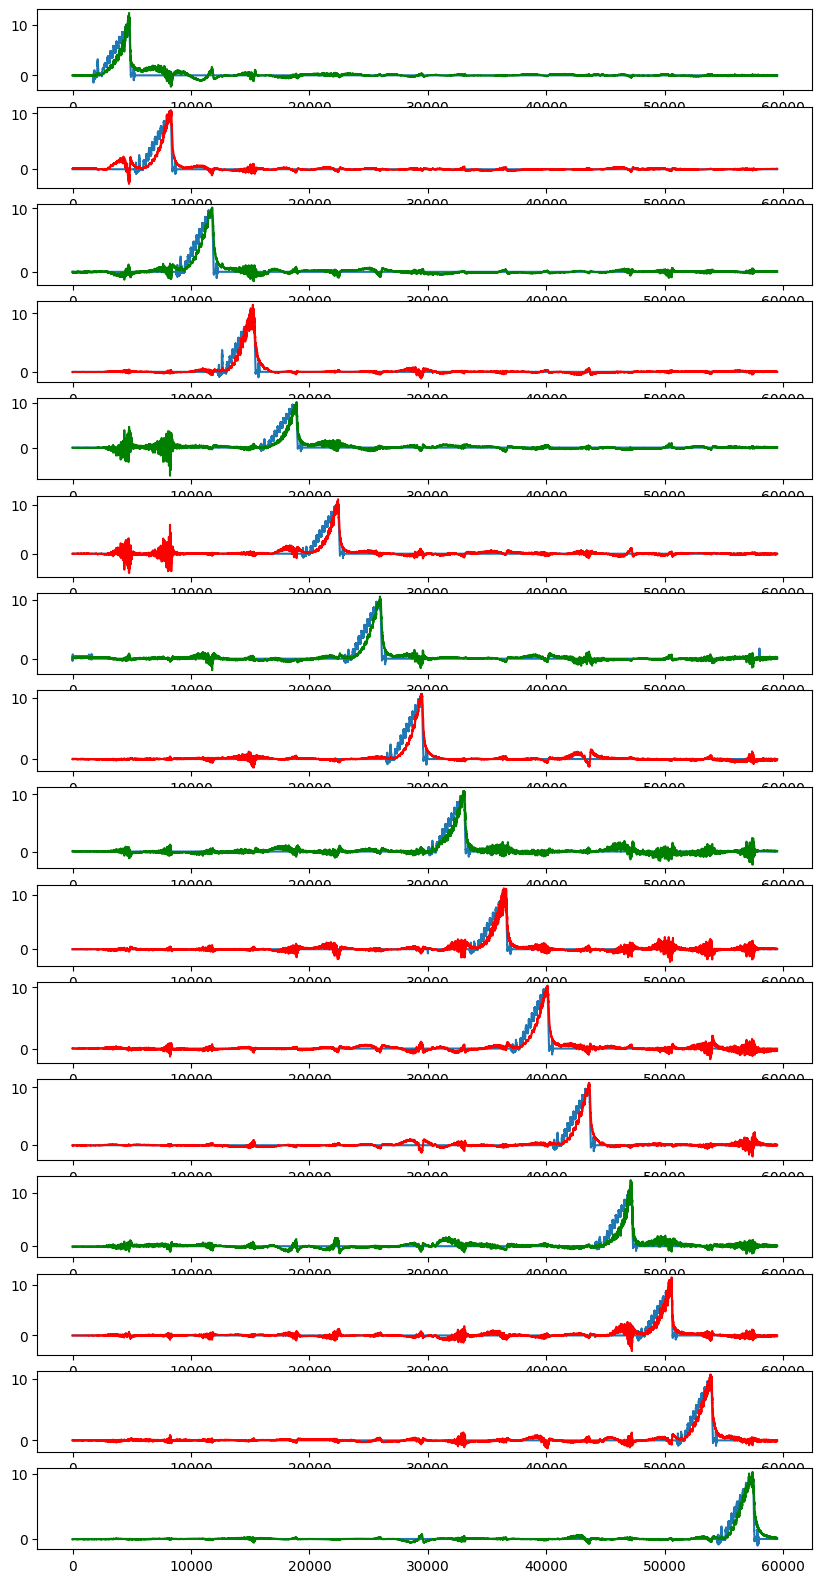

In [127]:
#
# AGGREGATED MODEL PER VIRTUAL TAXEL (UNCOUPLED)
#
# # 
# # 
# # "Training check": just to see if the models are fitted OK
# int_F_z = []
# for F_zi, model in zip(F_zis, aggregate_models):
    
#     X = F_zi
#     int_F_z.append(model.predict(X))
    
# fig, axs = plt.subplots(array_sub_size, 1, figsize=(10, 20))
# for i in range(array_sub_size):
#   c = 'r'
#   if i == 0 or i == 2 or i == 6 or i == 8:
#     c = 'g'
    
#   axs[i].plot(full_regions_sr[i][f'F_z'])
#   axs[i].plot(int_F_z[i], c=c)

#
# ONE BIG AGGREGATED MODEL
#
# "Training check": just to see if the models are fitted OK
y_pred = big_aggregated_model.predict(np.array(F_zi).T) 

# Plot
fig, axs = plt.subplots(array_sub_size, 1, figsize=(10, 20))
for i in range(array_sub_size):
  c = 'r'
  if array_sub_size == 9 and i == 0 or i == 2 or i == 6 or i == 8:
    c = 'g'
  
  if array_sub_size == 16 and i == 0 or i == 4 or i == 12 or i == 15:
    c = 'g'
    
  axs[i].plot(full_regions_sr[i][f'F_z'])
  axs[i].plot(y_pred[:, i], c=c)

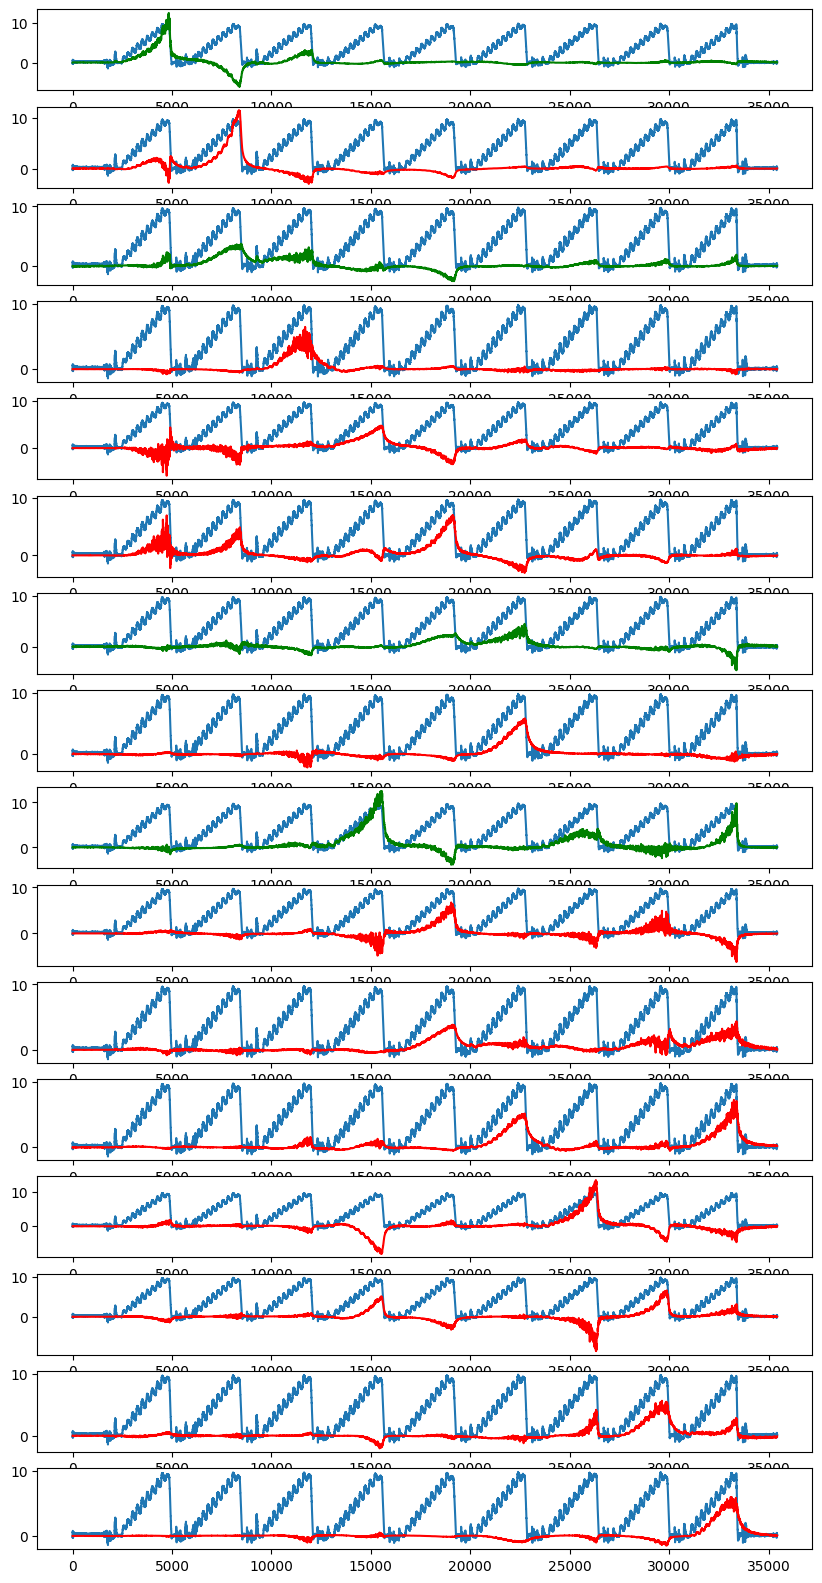

In [129]:
#
# AGGREGATED MODEL PER VIRTUAL TAXEL (UNCOUPLED)
#
# # Validation test. Now do the same, but on a complete dataset
# super_res_df_val = cf.prepare_data_for_fitting(f"table_calibration/2x2_grid_subsampling_x2_08032024_schroef2", array_size, SENSOR_LAG)

# # First convert measurements to F_zi
# X = super_res_df_val[[f'Z{i}' for i in range(array_size)]]
# F_zi = []
# for model in normal_force_models_taxels:
#     F_zi.append(model.predict(X[f'Z{model.activation_index}'].to_numpy().reshape(-1, 1))[:, 0])
# F_zi = np.array(F_zi).T
# print(F_zi.shape)

# # Plot F_zi
# fig, axs = plt.subplots(array_size, 1)
# for i in range(array_size):
#   axs[i].plot(super_res_df_val[f'F_z'])
#   axs[i].plot(F_zi[:, i])

# # Then use the aggregate model to predict the F_z in the virtual taxels
# int_F_z = []
# for model in aggregate_models:
#     X = F_zi
#     int_F_z.append(model.predict(X))
    
# # Plot!
# fig, axs = plt.subplots(array_sub_size, 1, figsize=(10, 20))
# for i in range(array_sub_size):
#   c = 'r'
#   if i == 0 or i == 2 or i == 6 or i == 8:
#     c = 'g'
    
#   axs[i].plot(super_res_df_val[f'F_z'])
#   axs[i].plot(int_F_z[i], c=c)
#   axs[i].set_ylim((0, 10))

#
# ONE BIG AGGREGATED MODEL
#
# "Training check": just to see if the models are fitted OK
super_res_df_val = cf.prepare_data_for_fitting(f"table_calibration/2x2_grid_subsampling_x2_08032024_schroef2", array_size, SENSOR_LAG)

# First convert measurements to F_zi
X = super_res_df_val[[f'Z{i}' for i in range(array_size)]]
F_zi = []
for model in normal_force_models_taxels:
    F_zi.append(model.predict(X[f'Z{model.activation_index}'].to_numpy().reshape(-1, 1))[:, 0])
F_zi = np.array(F_zi).T
    
# Convert to virtual taxels F_z
y_pred = big_aggregated_model.predict(F_zi) 

# Plot
fig, axs = plt.subplots(array_sub_size, 1, figsize=(10, 20))
for i in range(array_sub_size):
  c = 'r'
  if i == 0 or i == 2 or i == 6 or i == 8:
    c = 'g'
    
  axs[i].plot(super_res_df_val[f'F_z'])
  axs[i].plot(y_pred[:, i], c=c)

In [ ]:
# 

In [ ]:
# 